In [2]:
!pip install scikit-posthocs

In [3]:
!pip install researchpy

In [5]:

import pandas as pd
import numpy as np
import pickle
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import itertools
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy import stats
import scikit_posthocs as ph
import researchpy as rp

In [6]:
h1b1 = pd.read_csv('data/cleaned_for_testing.csv')

H0: The mean salary of all roles are equal
H1: The mean salary of all roles at least one month group is different

H0: The mean salary of all regions are equal
H1: The mean salary of at least one region is different

H0: There is no interaction between the role and region
H1: There is interaction between the role and region 

In [11]:
keep = dict(zip(h1b1.columns,[x.title() for x in h1b1.columns]))
h1b1 = h1b1.rename(columns=keep)

In [12]:
h1b1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8550 entries, 0 to 8549
Data columns (total 10 columns):
Company       8550 non-null object
Location      8550 non-null object
Role          8550 non-null object
Salary        8550 non-null int64
Startdate     8550 non-null object
Status        8550 non-null object
Submitdate    8550 non-null object
Year          8550 non-null int64
Region        8550 non-null object
Industry      8550 non-null object
dtypes: int64(2), object(8)
memory usage: 668.0+ KB


In [8]:
h1b1.head()

,company,location,role,salary,startdate,status,submitdate,year,region,industry
0,THE MATLEN SILVER GROUP INC,"CHARLOTTE, NC",DATA SCIENTIST,170000,01/05/2015,CERTIFIED,12/12/2014,2014,OTHER,OTHER
1,THOUGHTWORKS INC,"CHICAGO, IL",DATA SCIENTIST,71718,09/29/2014,CERTIFIED,09/29/2014,2014,OTHER,OTHER
2,EVANTAGE SOLUTIONS INC,"BELLEVUE, WA",DATA SCIENTIST,73923,12/15/2014,CERTIFIED,12/15/2014,2014,OTHER,OTHER
3,HOTWIRE INC,"BELLEVUE, WA",DATA SCIENTIST,74755,10/20/2014,CERTIFIED,10/08/2014,2014,OTHER,TECH
4,FINO CONSULTING LLC,"NEW YORK, NY",DATA SCIENTIST,82000,10/20/2014,CERTIFIED,10/16/2014,2014,NYC,CONSULTING


In [9]:
h1b1.describe().T

,count,mean,std,min,25%,50%,75%,max
salary,8550.0,108797.034386,29678.270711,5769.0,86520.0,105810.0,129187.0,312000.0
year,8550.0,2017.581520,1.290104,2014.0,2017.0,2018.0,2019.0,2019.0


## 6 ANOVA Assumptions
1. "The dependent variable should be measured at the continuous level (i.e., it is an interval or ratio variable)."
2. "Your three independent variables should each consist of two or more categorical, independent groups"
3. "You should have independence of observations, which means that there is no relationship between the observations in each group or between the groups themselves"
4. "There should be no significant outliers"
5. "Your dependent variable should be approximately normally distributed for each combination of the groups of the three independent variables" (Shapiro-Wilk test)
6. "Homogeneity of variances for each combination of the groups of the three independent variables" Levene's test

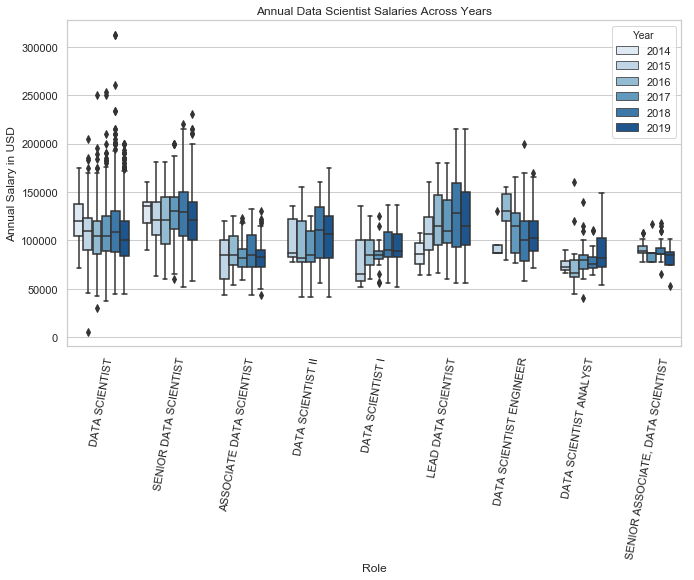

In [13]:
# Let's visually check the distribution of our dependent variable accross experience
sns.set(style="whitegrid")
dims = (11, 6)
fig, ax = plt.subplots(figsize=dims)
ax = sns.boxplot(x=h1b1["Role"],
                 y=h1b1['Salary'], hue=h1b1['Year'], palette='Blues')
plt.xticks(rotation=80)
plt.ylabel("Annual Salary in USD")
plt.title("Annual Data Scientist Salaries Across Years")
plt.show()

Comparing accross more than two years is problematic so lets see when the bulk of our data comes from.

In [16]:
h1b1.groupby('Year')['Salary'].agg(['count'])

,count
Year,
2014,82
2015,658
2016,1101
2017,1581
2018,2621
2019,2507


So the bulk of our data comes from the last four years. Let's focus on the last three as they account for over half the data and they are the most recent and therefore likely to be the most relevant.

In [17]:
years = list(h1b1.Year.unique())
years

[2014, 2015, 2016, 2017, 2018, 2019]

In [18]:
recent_years = years [3:6]
recent_years

[2017, 2018, 2019]

In [19]:
def slice_by_year(df, year):
    slice_df = df[df['Year'] == year]
    return slice_df

In [20]:
for year in recent_years:
    print(year)
    display(slice_by_year(h1b1, year).describe().T)

2017


,count,mean,std,min,25%,50%,75%,max
Salary,1581.0,108623.705882,29184.652759,37482.0,87000.0,107000.0,127046.0,253630.0
Year,1581.0,2017.000000,0.000000,2017.0,2017.0,2017.0,2017.0,2017.0


2018


,count,mean,std,min,25%,50%,75%,max
Salary,2621.0,111927.863029,31885.622452,43056.0,87859.0,110000.0,132000.0,312000.0
Year,2621.0,2018.000000,0.000000,2018.0,2018.0,2018.0,2018.0,2018.0


2019


,count,mean,std,min,25%,50%,75%,max
Salary,2507.0,106446.04627,28836.65483,41246.0,85000.0,100506.0,125000.0,231000.0
Year,2507.0,2019.00000,0.00000,2019.0,2019.0,2019.0,2019.0,2019.0


We should also get rid of outliers which is more easily done on the overall dataframe.

In [21]:
before_drop = len(h1b1)
h1b1 = h1b1[h1b1['Salary']>40000]# three values, likely typos or atypical contracts
h1b1 = h1b1[h1b1['Salary']<300000] # two values, larson living labs
h1b1 = h1b1.drop_duplicates()# several repeat entries
print(str(round(before_drop/len(h1b1)*100, 1)) + '%')

100.1%


In [22]:
h1b1.groupby('Role')['Salary'].nunique().sort_values(ascending=False)[0:5]

Role
DATA SCIENTIST              1480
SENIOR DATA SCIENTIST        458
DATA SCIENTIST II            119
ASSOCIATE DATA SCIENTIST     118
LEAD DATA SCIENTIST           94
Name: Salary, dtype: int64

In [23]:
for year in recent_years:
    print(year)
    print(slice_by_year(h1b1, year).groupby('Role')['Salary'].nunique().sort_values(ascending=False)[0:5], "\n")

2017
Role
DATA SCIENTIST              410
SENIOR DATA SCIENTIST       119
ASSOCIATE DATA SCIENTIST     30
LEAD DATA SCIENTIST          25
DATA SCIENTIST II            21
Name: Salary, dtype: int64 

2018
Role
DATA SCIENTIST              613
SENIOR DATA SCIENTIST       199
DATA SCIENTIST II            47
LEAD DATA SCIENTIST          40
ASSOCIATE DATA SCIENTIST     38
Name: Salary, dtype: int64 

2019
Role
DATA SCIENTIST              471
SENIOR DATA SCIENTIST       198
DATA SCIENTIST II           119
LEAD DATA SCIENTIST          94
ASSOCIATE DATA SCIENTIST     58
Name: Salary, dtype: int64 



Given the size let's take the top 4 values in the top 3 years

In [24]:
data_scientists = h1b1[h1b1['Role'] == 'DATA SCIENTIST']
senior_data_scientists = h1b1[h1b1['Role'] == 'SENIOR DATA SCIENTIST']
lead_data_scientists = h1b1[h1b1['Role'] == 'LEAD DATA SCIENTIST']
associate_data_scientists = h1b1[h1b1['Role'] == 'ASSOCIATE DATA SCIENTIST']

In [25]:
top_4_roles_all_years = pd.concat([data_scientists, senior_data_scientists, lead_data_scientists, associate_data_scientists]) 
len(top_4_roles_all_years)

7763

Finally lets get dataframes for each year.

In [26]:
top_4_roles_2017 = slice_by_year(top_4_roles_all_years, 2017)
top_4_roles_2018 = slice_by_year(top_4_roles_all_years, 2018)
top_4_roles_2019 = slice_by_year(top_4_roles_all_years, 2019)

In [27]:
# # set([x for x in slice_by_year(h1b1,year)])
# roles_2017 = list(set([x for x in h1b1_2017.Role]))
# for role in roles_2017:
#     shapiro_test = stats.shapiro(h1b1_2017[h1b1_2017['Role'] == role]["Salary"])
#     p_value = shapiro_test[1]
#     if p_value > 0.05:
#         print(f"{role}: p-value={p_value}, SATISFIES #5.")
#     else:
#         print(f"{role}: p-value={p_value}, DOES NOT satisfy #5.")

In [28]:
# stats.shapiro(h1b1_2014[h1b1_2014['Role'] == 'SENIOR DATA SCIENTIST']["Salary"])

In [29]:
for year in recent_years:
    top_4_roles_year = slice_by_year(top_4_roles_all_years,year)
    display(rp.summary_cont(top_4_roles_year['Salary']).round(2))

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,Salary,1463.0,110214.78,29067.85,759.96,108724.05,111705.51


,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,Salary,2401.0,113122.5,31531.73,643.5,111860.62,114384.38


,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,Salary,2152.0,107216.72,29263.41,630.82,105979.64,108453.79


In [30]:
for year in recent_years:
    top_4_roles_year = slice_by_year(top_4_roles_all_years,year)
    display(rp.summary_cont(top_4_roles_year.groupby(['Role']))['Salary'].round(2))

,N,Mean,SD,SE,95% Conf.,Interval
Role,,,,,,
ASSOCIATE DATA SCIENTIST,38,84024.71,16873.65,2737.27,78659.67,89389.76
DATA SCIENTIST,1171,106921.73,27709.88,809.76,105334.60,108508.86
LEAD DATA SCIENTIST,31,119688.58,31724.15,5697.83,108520.84,130856.32
SENIOR DATA SCIENTIST,223,130652.87,26972.54,1806.21,127112.69,134193.06


,N,Mean,SD,SE,95% Conf.,Interval
Role,,,,,,
ASSOCIATE DATA SCIENTIST,60,86975.65,21153.58,2730.92,81623.06,92328.24
DATA SCIENTIST,1898,110309.97,30487.86,699.81,108938.35,111681.60
LEAD DATA SCIENTIST,46,125329.93,39067.80,5760.23,114039.88,136619.99
SENIOR DATA SCIENTIST,397,129106.00,30298.43,1520.63,126125.56,132086.45


,N,Mean,SD,SE,95% Conf.,Interval
Role,,,,,,
ASSOCIATE DATA SCIENTIST,80,83138.15,16323.69,1825.04,79561.06,86715.24
DATA SCIENTIST,1522,102896.36,26606.15,681.98,101559.67,104233.05
LEAD DATA SCIENTIST,141,122314.33,34983.80,2946.17,116539.85,128088.82
SENIOR DATA SCIENTIST,409,122798.88,29978.62,1482.35,119893.47,125704.28


In [68]:
for year in recent_years:
    top_4_roles_year = slice_by_year(top_4_roles_all_years,year)
    display(rp.summary_cont(top_4_roles_year.groupby(['Region']))['Salary'].round(2))

,N,Mean,SD,SE,95% Conf.,Interval
Region,,,,,,
BAYAREA,522,123659.38,26971.30,1180.50,121345.60,125973.16
DC,18,99990.78,17700.75,4172.11,91813.45,108168.11
NYC,124,111308.84,28458.27,2555.63,106299.81,116317.87
OTHER,799,101491.74,27287.05,965.35,99599.66,103383.82


,N,Mean,SD,SE,95% Conf.,Interval
Region,,,,,,
BAYAREA,830,132316.41,28950.27,1004.88,130346.85,134285.97
DC,40,102118.40,26623.06,4209.47,93867.83,110368.97
NYC,228,115446.03,28568.58,1892.00,111737.71,119154.35
OTHER,1303,100827.38,27290.08,756.02,99345.58,102309.18


,N,Mean,SD,SE,95% Conf.,Interval
Region,,,,,,
BAYAREA,595,128301.97,27185.10,1114.48,126117.59,130486.35
DC,38,95006.11,17914.80,2906.16,89310.02,100702.19
NYC,228,109313.25,29329.75,1942.41,105506.13,113120.38
OTHER,1291,97488.03,24941.53,694.16,96127.48,98848.59


In [32]:
for year in recent_years:
    top_4_roles_year = slice_by_year(top_4_roles_all_years,year)
    display(rp.summary_cont(top_4_roles_year.groupby(['Role', 'Region']))['Salary'].round(2))

C:\ProgramData\Anaconda3\lib\site-packages\researchpy\summary.py:151: RuntimeWarning: invalid value encountered in double_scalars
  l_ci = lambda x: numpy.mean(x) - (1.960 * (numpy.std(x)/numpy.sqrt(x.count() - 1)))
C:\ProgramData\Anaconda3\lib\site-packages\researchpy\summary.py:154: RuntimeWarning: invalid value encountered in double_scalars
  u_ci = lambda x: numpy.mean(x) + (1.960 * (numpy.std(x)/numpy.sqrt(x.count() - 1)))


N       Mean        SD       SE  \
Role                     Region                                       
ASSOCIATE DATA SCIENTIST BAYAREA    7   96660.57  19002.25  7182.17   
                         DC         1   80000.00       NaN      NaN   
                         NYC        2   69500.00   7778.17  5500.00   
                         OTHER     28   82046.96  15684.77  2964.14   
DATA SCIENTIST           BAYAREA  431  120507.66  26106.11  1257.49   
                         DC        10   95100.00  16360.18  5173.54   
                         NYC       98  108634.18  26482.20  2675.11   
                         OTHER    632   97578.16  25129.26   999.59   
LEAD DATA SCIENTIST      BAYAREA    9  142192.78  25549.31  8516.44   
                         DC         1  130000.00       NaN      NaN   
                         NYC        3   82895.00  14073.84  8125.54   
                         OTHER     18  113995.89  29966.12  7063.08   
SENIOR DATA SCIENTIST    BAYAREA   75  142067.12  23442.65  2706.92   
                         DC         6  106472.33  15006.91  6126.55   
                         NYC       21  131831.48  27988.52  6107.60   
                         OTHER    121  124572.41  26812.02  2437.46   

                                  95% Conf.   Interval  
Role                     Region                         
ASSOCIATE DATA SCIENTIST BAYAREA   82583.51  110737.63  
                         DC             NaN        NaN  
                         NYC       58720.00   80280.00  
                         OTHER     76237.25   87856.68  
DATA SCIENTIST           BAYAREA  118042.99  122972.34  
                         DC        84959.85  105240.15  
                         NYC      103390.98  113877.39  
                         OTHER     95618.97   99537.35  
LEAD DATA SCIENTIST      BAYAREA  125500.56  158885.00  
                         DC             NaN        NaN  
                         NYC       66968.95   98821.05  
                         OTHER    100152.25  127839.53  
SENIOR DATA SCIENTIST    BAYAREA  136761.55  147372.69  
                         DC        94464.30  118480.36  
                         NYC      119860.59  143802.36  
                         OTHER    119795.00  129349.83

N       Mean        SD        SE  \
Role                     Region                                         
ASSOCIATE DATA SCIENTIST BAYAREA    13  104565.00  16730.56   4640.22   
                         DC          1   70574.00       NaN       NaN   
                         NYC         6  101833.33  29137.03  11895.14   
                         OTHER      40   79440.50  16725.94   2644.60   
DATA SCIENTIST           BAYAREA   666  130261.67  28599.37   1108.20   
                         DC         32   97219.66  21542.89   3808.28   
                         NYC       169  110328.30  25613.63   1970.28   
                         OTHER    1031   97824.97  25379.63    790.42   
LEAD DATA SCIENTIST      BAYAREA    17  139238.65  30231.42   7332.20   
                         NYC         5  138680.00  56032.24  25058.38   
                         OTHER      24  112696.67  38159.58   7789.29   
SENIOR DATA SCIENTIST    BAYAREA   134  144342.88  27403.79   2367.33   
                         DC          7  129019.00  32729.29  12370.51   
                         NYC        48  132746.10  27539.08   3974.92   
                         OTHER     208  118452.84  28337.46   1964.85   

                                  95% Conf.   Interval  
Role                     Region                         
ASSOCIATE DATA SCIENTIST BAYAREA   95470.16  113659.84  
                         DC             NaN        NaN  
                         NYC       78518.85  125147.82  
                         OTHER     74257.08   84623.92  
DATA SCIENTIST           BAYAREA  128089.60  132433.75  
                         DC        89755.42  104683.89  
                         NYC      106466.55  114190.04  
                         OTHER     96275.75   99374.19  
LEAD DATA SCIENTIST      BAYAREA  124867.54  153609.75  
                         NYC       89565.58  187794.42  
                         OTHER     97429.65  127963.68  
SENIOR DATA SCIENTIST    BAYAREA  139702.92  148982.84  
                         DC       104772.80  153265.20  
                         NYC      124955.25  140536.95  
                         OTHER    114601.74  122303.95

N       Mean        SD        SE  \
Role                     Region                                        
ASSOCIATE DATA SCIENTIST BAYAREA   12  103914.92  17412.77   5026.63   
                         DC         2   78988.00  14340.13  10140.00   
                         NYC        4   91116.00  23877.81  11938.91   
                         OTHER     62   78736.02  12233.13   1553.61   
DATA SCIENTIST           BAYAREA  413  124009.73  25493.82   1254.47   
                         DC        28   91631.54  14073.00   2659.55   
                         NYC      157  105658.32  26671.85   2128.65   
                         OTHER    924   93331.39  21311.51    701.10   
LEAD DATA SCIENTIST      BAYAREA   46  132381.24  29637.90   4369.87   
                         DC         3  108320.33  22585.87  13039.96   
                         NYC       22  117117.00  41234.99   8791.33   
                         OTHER     70  117932.13  35691.55   4265.96   
SENIOR DATA SCIENTIST    BAYAREA  124  143444.65  26195.44   2352.42   
                         DC         5  112322.40  24690.48  11041.92   
                         NYC       45  119867.27  29039.71   4328.98   
                         OTHER    235  112689.21  26547.94   1731.80   

                                  95% Conf.   Interval  
Role                     Region                         
ASSOCIATE DATA SCIENTIST BAYAREA   94062.71  113767.12  
                         DC        59113.60   98862.40  
                         NYC       67715.75  114516.25  
                         OTHER     75690.94   81781.09  
DATA SCIENTIST           BAYAREA  121550.97  126468.49  
                         DC        86418.82   96844.25  
                         NYC      101486.18  109830.47  
                         OTHER     91957.24   94705.54  
LEAD DATA SCIENTIST      BAYAREA  123816.29  140946.18  
                         DC        82762.02  133878.65  
                         NYC       99885.99  134348.01  
                         OTHER    109570.86  126293.40  
SENIOR DATA SCIENTIST    BAYAREA  138833.91  148055.40  
                         DC        90680.24  133964.56  
                         NYC      111382.46  128352.07  
                         OTHER    109294.89  116083.53

In [33]:
top_4_roles_2019['Industry'].unique()

array(['OTHER', 'CONSULTING', 'FINANCE', 'TECH', 'INSURANCE'],
      dtype=object)

In [34]:
display(rp.summary_cont(top_4_roles_2018.groupby(['Region']))['Salary'].round(2))

,N,Mean,SD,SE,95% Conf.,Interval
Region,,,,,,
BAYAREA,830,132316.41,28950.27,1004.88,130346.85,134285.97
DC,40,102118.40,26623.06,4209.47,93867.83,110368.97
NYC,228,115446.03,28568.58,1892.00,111737.71,119154.35
OTHER,1303,100827.38,27290.08,756.02,99345.58,102309.18


In [35]:
test = [top_4_roles_2017,top_4_roles_2018]

In [36]:
def create_sample_dists(cleaned_data, y_var=None, category=None, sample_size=5):
    """
    Each hypothesis test will require you to create a sample distribution from your data
    Best make a repeatable function

    :param cleaned_data:
    :param y_var: The numeric variable you are comparing
    :param categories: the categories whose means you are comparing
    :return: a list of sample distributions to be used in subsequent t-tests

    """
    groups = list(cleaned_data[category].unique())
    print(groups)
    htest_dfs = []
    for group in groups:
        sample = cleaned_data[cleaned_data[category]==group][y_var].sample(sample_size)
        htest_dfs.append(sample)

    # Main chunk of code using t-tests or z-tests
    return htest_dfs

In [37]:
create_sample_dists(top_4_roles_2018, y_var='Salary', category='Role')

['DATA SCIENTIST', 'SENIOR DATA SCIENTIST', 'LEAD DATA SCIENTIST', 'ASSOCIATE DATA SCIENTIST']


[2753     70000
 2605     82860
 4082    134014
 3912    123000
 4344    155000
 Name: Salary, dtype: int64, 6668    150000
 6700    158000
 6585    129210
 6491     99000
 6474     92414
 Name: Salary, dtype: int64, 8097    160000
 8093    153000
 8103    168189
 8071     90000
 8067     75000
 Name: Salary, dtype: int64, 7094    60000
 7104    73110
 7098    65229
 7095    60000
 7102    70574
 Name: Salary, dtype: int64]

In [38]:
groups = list(top_4_roles_all_years['Year'].unique())
frames = []
for group in groups:
    sample = top_4_roles_all_years[(top_4_roles_all_years['Year']==group)]['Salary'].sample(5)
    frames.append(sample)
frames

[10       91374
 9        90870
 33      120000
 6017    146000
 48      135000
 Name: Salary, dtype: int64, 509    131616
 167     85000
 330    110000
 142     80000
 83      57500
 Name: Salary, dtype: int64, 772      83500
 1130    115000
 6196    135000
 982     102000
 1198    120000
 Name: Salary, dtype: int64, 2519    150000
 7083    115000
 6259     94536
 8039     95243
 2445    140000
 Name: Salary, dtype: int64, 7825    140000
 6614    135000
 2619    100000
 4269    150000
 3920    125000
 Name: Salary, dtype: int64, 7949    130000
 5078     91000
 5407    105000
 7874     95172
 8133     89648
 Name: Salary, dtype: int64]

### Simulated Hypothesis Test on Region

In [39]:
sample_dc = top_4_roles_2018[(top_4_roles_2018['Region']=='DC')].sample(5)
sample_bayarea = top_4_roles_2018[(top_4_roles_2018['Region']=='BAYAREA')].sample(5)
sample_nyc = top_4_roles_2018[(top_4_roles_2018['Region']=='NYC')].sample(5)
sample_other = top_4_roles_2018[(top_4_roles_2018['Region']=='OTHER')].sample(5)

In [40]:
samples_assembled = pd.concat([sample_bayarea, sample_dc, sample_nyc, sample_other])

In [41]:
stats.levene(samples_assembled['Salary'][samples_assembled['Region'] == 'DC'],
             samples_assembled['Salary'][samples_assembled['Region'] == 'NYC'],
             samples_assembled['Salary'][samples_assembled['Region'] == 'BAYAREA'], 
             samples_assembled['Salary'][samples_assembled['Region'] == 'OTHER'])

LeveneResult(statistic=0.2032671002895928, pvalue=0.8926127581781315)

In [42]:
# sm.stats.anova_lm(lm, typ=2)[]

SyntaxError: invalid syntax (<ipython-input-42-9cf284c17df2>, line 1)

In [44]:
print(f"Oneway ANOVA test for Regions")
formula = 'Salary ~ C(Region)'
lm = ols(formula, samples_assembled).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table, "\n")
print(lm.summary())
# display(lm.summary())
shapiro_test = stats.shapiro(lm.resid)
p_value = shapiro_test[1]
print(f"Shapiro-Wilk test")
if p_value > 0.05:
    print(f"{year}: p-value={p_value}, SATISFIES #5.")
else:
    print(f"{year}: p-value={p_value}, DOES NOT satisfy #5.")
print("------------\n")

Oneway ANOVA test for Regions
                 sum_sq    df         F    PR(>F)
C(Region)  1.281334e+10   3.0  7.964198  0.001792
Residual   8.580630e+09  16.0       NaN       NaN 

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.599
Model:                            OLS   Adj. R-squared:                  0.524
Method:                 Least Squares   F-statistic:                     7.964
Date:                Fri, 23 Aug 2019   Prob (F-statistic):            0.00179
Time:                        13:44:52   Log-Likelihood:                -227.15
No. Observations:                  20   AIC:                             462.3
Df Residuals:                      16   BIC:                             466.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coe

In [45]:
aov_table = sm.stats.anova_lm(lm, typ=2)
def anova_table(aov):
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']
    
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])
    
    cols = ['sum_sq', 'df', 'mean_sq', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov
anova_table(aov_table)

,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
C(Region),1.281334e+10,3.0,4.271114e+09,7.964198,0.001792,0.598923,0.510914
Residual,8.580630e+09,16.0,5.362893e+08,NaN,NaN,NaN,NaN


### Overall Sample Tests
Let's do a two-way ANOVA for our of our largest complete years.

In [70]:
for year in recent_years:
    print(f"Twoway ANOVA test for {year}")
    top_4_roles_year = slice_by_year(top_4_roles_all_years,year)
    formula = 'Salary ~ C(Role) + C(Region)'
    lm = ols(formula, top_4_roles_year).fit()
    table = sm.stats.anova_lm(lm, typ=2)
    print(table, "\n")
    print(anova_table(table).round(3))
    print(lm.summary())
    shapiro_test = stats.shapiro(lm.resid)
    p_value = shapiro_test[1]
    print(f"Shapiro-Wilk test")
    if p_value > 0.05:
        print(f"{year}: p-value={p_value}, SATISFIES #5.")
    else:
        print(f"{year}: p-value={p_value}, DOES NOT satisfy #5.")
    print("------------\n")
#     roles = list(set([x for x in h1b1_year.Role]))
#     for role in roles:
#         shapiro_test = stats.shapiro(lm.resid)
#         p_value = shapiro_test[1]
#         if p_value > 0.05:
#             print(f"{role}: p-value={p_value}, SATISFIES #5.")
#         else:
#             print(f"{role}: p-value={p_value}, DOES NOT satisfy #5.")

Twoway ANOVA test for 2017
                 sum_sq      df          F        PR(>F)
C(Role)    1.338474e+11     3.0  68.794328  1.324504e-41
C(Region)  1.563333e+11     3.0  80.351548  4.213683e-48
Residual   9.442727e+11  1456.0        NaN           NaN 

                 sum_sq      df       mean_sq       F  PR(>F)  eta_sq  \
C(Role)    1.338474e+11     3.0  4.461580e+10  68.794     0.0   0.108   
C(Region)  1.563333e+11     3.0  5.211111e+10  80.352     0.0   0.127   
Residual   9.442727e+11  1456.0  6.485390e+08     NaN     NaN     NaN   

           omega_sq  
C(Role)       0.107  
C(Region)     0.125  
Residual        NaN  
                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.236
Model:                            OLS   Adj. R-squared:                  0.232
Method:                 Least Squares   F-statistic:                     74.79
Date:                Fri, 23 Aug 2019   Prob (

In [47]:
# just_ds = h1b1[h1b1['Role'] == 'DATA SCIENTIST']
# just_ds.head()

In [48]:
# print(len(senior_ds))
# print(len(just_ds))
# print(len(senior_ds) + len(just_ds))

In [49]:
# senior_and_just_ds = pd.concat([senior_ds, just_ds])
# senior_and_just_ds.head()

In [50]:
# len(senior_and_just_ds)

So our ANOVA in both years fails the 5th assumption (not surprising since it's not a random sample)...on to non-parametric tests!

In [51]:
for year in recent_years:
    top_4_roles_year = slice_by_year(top_4_roles_all_years,year)
    stat, p = stats.kruskal(top_4_roles_year[top_4_roles_year['Region'] == 'NYC'].Salary,
                            top_4_roles_year[top_4_roles_year['Region'] == 'DC'].Salary,
                            top_4_roles_year[top_4_roles_year['Region'] == 'BAYAREA'].Salary,
                            top_4_roles_year[top_4_roles_year['Region'] == 'OTHER'].Salary) 
    print(f"Kruskal-Wallis Test results for {year}'s data:")
    print('Statistics = %.3f, p = %.2f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print('Same distributions (fail to reject H0) \n')
    else:
        print('Different distributions (reject H0) \n')

Kruskal-Wallis Test results for 2017's data:
Statistics = 201.012, p = 0.00
Different distributions (reject H0) 

Kruskal-Wallis Test results for 2018's data:
Statistics = 532.218, p = 0.00
Different distributions (reject H0) 

Kruskal-Wallis Test results for 2019's data:
Statistics = 485.873, p = 0.00
Different distributions (reject H0) 



In [63]:
df_region_2017 = ph.posthoc_conover(slice_by_year(top_4_roles_all_years,2017),
                        val_col='Salary', group_col='Region', p_adjust = 'holm')
print(2017)
display(df.round(3))

2017


,BAYAREA,DC,NYC,OTHER
BAYAREA,-1.000,0.001,0.000,0.000
DC,0.001,-1.000,0.184,0.808
NYC,0.000,0.184,-1.000,0.001
OTHER,0.000,0.808,0.001,-1.000


In [65]:
df_region_2017 = ph.posthoc_conover(slice_by_year(top_4_roles_all_years,2017),
                        val_col='Salary', group_col='Region', p_adjust = 'holm')
df_region_2018 = ph.posthoc_conover(slice_by_year(top_4_roles_all_years,2018),
                        val_col='Salary', group_col='Region', p_adjust = 'holm')
df_region_2019 = ph.posthoc_conover(slice_by_year(top_4_roles_all_years,2019),
                        val_col='Salary', group_col='Region', p_adjust = 'holm')
display(df_region_2017.round(3),df_region_2018.round(3),df_region_2019.round(3))

,BAYAREA,DC,NYC,OTHER
BAYAREA,-1.000,0.001,0.000,0.000
DC,0.001,-1.000,0.184,0.808
NYC,0.000,0.184,-1.000,0.001
OTHER,0.000,0.808,0.001,-1.000


,BAYAREA,DC,NYC,OTHER
BAYAREA,-1.0,0.000,0.000,0.00
DC,0.0,-1.000,0.003,0.97
NYC,0.0,0.003,-1.000,0.00
OTHER,0.0,0.970,0.000,-1.00


,BAYAREA,DC,NYC,OTHER
BAYAREA,-1.0,0.000,0.000,0.000
DC,0.0,-1.000,0.005,0.704
NYC,0.0,0.005,-1.000,0.000
OTHER,0.0,0.704,0.000,-1.000


In [62]:
df = ph.posthoc_conover(slice_by_year(top_4_roles_all_years,2018),
                        val_col='Salary', group_col='Region', p_adjust = 'holm')
print(2019)
display(df.round(3))

,BAYAREA,DC,NYC,OTHER
BAYAREA,-1.0,0.000,0.000,0.00
DC,0.0,-1.000,0.003,0.97
NYC,0.0,0.003,-1.000,0.00
OTHER,0.0,0.970,0.000,-1.00


In [53]:
for year in recent_years:
    roles = list(set([x for x in slice_by_year(top_4_roles_all_years, year).Role]))
    combos = list(itertools.combinations(roles, 2))
    top_4_roles_year = slice_by_year(top_4_roles_all_years,year)
    stat, p = stats.kruskal(top_4_roles_year[top_4_roles_year['Role'] == roles[0]].Salary,
                            top_4_roles_year[top_4_roles_year['Role'] == roles[1]].Salary,
                            top_4_roles_year[top_4_roles_year['Role'] == roles[2]].Salary,
                            top_4_roles_year[top_4_roles_year['Role'] == roles[3]].Salary) 
    print(f"Kruskal-Wallis Test results for {year}'s data:")
    print('Statistics = %.3f, p = %.2f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print('Same distributions (fail to reject H0) \n')
    else:
        print('Different distributions (reject H0) \n')

Kruskal-Wallis Test results for 2017's data:
Statistics = 162.000, p = 0.00
Different distributions (reject H0) 

Kruskal-Wallis Test results for 2018's data:
Statistics = 167.971, p = 0.00
Different distributions (reject H0) 

Kruskal-Wallis Test results for 2019's data:
Statistics = 235.676, p = 0.00
Different distributions (reject H0) 



In [66]:
df_role_2017 = ph.posthoc_conover(slice_by_year(top_4_roles_all_years,2017),
                        val_col='Salary', group_col='Role', p_adjust = 'holm')
df_role_2018 = ph.posthoc_conover(slice_by_year(top_4_roles_all_years,2018),
                        val_col='Salary', group_col='Role', p_adjust = 'holm')
df_role_2019 = ph.posthoc_conover(slice_by_year(top_4_roles_all_years,2019),
                        val_col='Salary', group_col='Role', p_adjust = 'holm')
display(df_role_2017.round(3),df_role_2018.round(3),df_role_2019.round(3))

,ASSOCIATE DATA SCIENTIST,DATA SCIENTIST,LEAD DATA SCIENTIST,SENIOR DATA SCIENTIST
ASSOCIATE DATA SCIENTIST,-1.0,0.000,0.000,0.000
DATA SCIENTIST,0.0,-1.000,0.038,0.000
LEAD DATA SCIENTIST,0.0,0.038,-1.000,0.038
SENIOR DATA SCIENTIST,0.0,0.000,0.038,-1.000


,ASSOCIATE DATA SCIENTIST,DATA SCIENTIST,LEAD DATA SCIENTIST,SENIOR DATA SCIENTIST
ASSOCIATE DATA SCIENTIST,-1.0,0.000,0.000,0.00
DATA SCIENTIST,0.0,-1.000,0.008,0.00
LEAD DATA SCIENTIST,0.0,0.008,-1.000,0.21
SENIOR DATA SCIENTIST,0.0,0.000,0.210,-1.00


,ASSOCIATE DATA SCIENTIST,DATA SCIENTIST,LEAD DATA SCIENTIST,SENIOR DATA SCIENTIST
ASSOCIATE DATA SCIENTIST,-1.0,0.0,0.000,0.000
DATA SCIENTIST,0.0,-1.0,0.000,0.000
LEAD DATA SCIENTIST,0.0,0.0,-1.000,0.346
SENIOR DATA SCIENTIST,0.0,0.0,0.346,-1.000


In [54]:
df = ph.posthoc_conover(slice_by_year(top_4_roles_all_years,2017),
                        val_col='Salary', group_col='Role', p_adjust = 'holm')
display(df.round(3))

,ASSOCIATE DATA SCIENTIST,DATA SCIENTIST,LEAD DATA SCIENTIST,SENIOR DATA SCIENTIST
ASSOCIATE DATA SCIENTIST,-1.0,0.000,0.000,0.000
DATA SCIENTIST,0.0,-1.000,0.038,0.000
LEAD DATA SCIENTIST,0.0,0.038,-1.000,0.038
SENIOR DATA SCIENTIST,0.0,0.000,0.038,-1.000


All combinations in our non-random sample fall below alpha so we can reject the null hypothesis: data science salaries for foreigners did differ significantly based on title (and by proxy, experience).

In [55]:
# let's try 2018
df = ph.posthoc_conover(slice_by_year(top_4_roles_all_years,2018),
                        val_col='Salary', group_col='Role', p_adjust = 'holm')
display(df.round(3))

,ASSOCIATE DATA SCIENTIST,DATA SCIENTIST,LEAD DATA SCIENTIST,SENIOR DATA SCIENTIST
ASSOCIATE DATA SCIENTIST,-1.0,0.000,0.000,0.00
DATA SCIENTIST,0.0,-1.000,0.008,0.00
LEAD DATA SCIENTIST,0.0,0.008,-1.000,0.21
SENIOR DATA SCIENTIST,0.0,0.000,0.210,-1.00


It looks like the difference between lead data scientists' and senior data scientists' salaries is not longer significant. Let's highlight that.

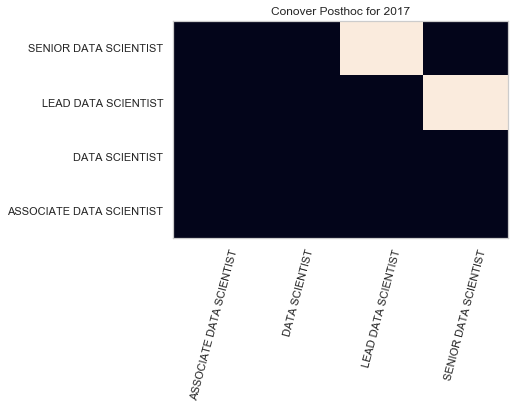

In [56]:
plt.pcolor(df, vmin=alpha)
plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation= 75)
plt.title("Conover Posthoc for 2017")
plt.show()

In [57]:
# Our guess is that this convergence continues in the first-third of 2019
df = ph.posthoc_conover(slice_by_year(top_4_roles_all_years,2019),
                        val_col='Salary', group_col='Role', p_adjust = 'holm')
display(df.round(3))

,ASSOCIATE DATA SCIENTIST,DATA SCIENTIST,LEAD DATA SCIENTIST,SENIOR DATA SCIENTIST
ASSOCIATE DATA SCIENTIST,-1.0,0.0,0.000,0.000
DATA SCIENTIST,0.0,-1.0,0.000,0.000
LEAD DATA SCIENTIST,0.0,0.0,-1.000,0.346
SENIOR DATA SCIENTIST,0.0,0.0,0.346,-1.000


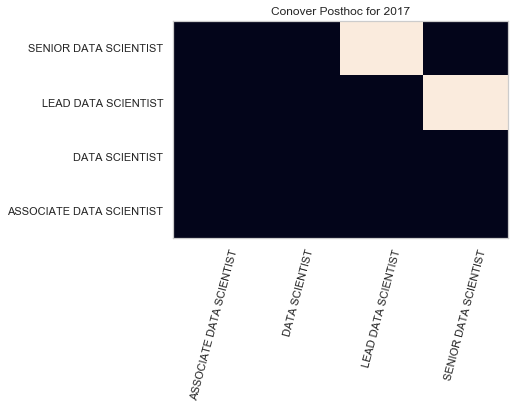

In [58]:
plt.pcolor(df, vmin=alpha)
plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation= 75)
plt.title("Conover Posthoc for 2017")
plt.show()

In [71]:
from scipy.stats import mannwhitneyu

In [ ]:
stat, p = mannwhitneyu(slice_by_year(top_4_roles_all_years, 2017)[top_4_roles_2017['']])